In [13]:
def foo(pred, target):
    import numpy as np
    return pred - target * np.log(pred)
print(foo(pred=2, target=10), ", ", foo(pred=10, target=2))

-4.931471805599453 ,  5.394829814011908


In [1]:
import pandas as pd
import numpy as np
import os
import scanpy as sc
import re

from umap import UMAP
import matplotlib.pyplot as plt
import seaborn as sns
import decoupler as dc
from composition_stats import closure, ilr

/Users/pschafer/miniconda3/envs/torch_env/lib/python3.8/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/Users/pschafer/miniconda3/envs/torch_env/lib/python3.8/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/Users/pschafer/miniconda3/envs/torch_env/lib/python3.8/si

In [2]:
# see deconv.py
def lookup(model_call, sample_entry):
    if model_call == "all":
        reg_model = "All"
    elif model_call == "condition":
        if sample_entry["Condition"] == "Control":
            reg_model = "Control"
        elif sample_entry["Condition"] == "MS":
            reg_model = "MS"
        else:
            raise ValueError("Unknown condition")
    elif model_call == "lesion_type":
        if sample_entry["lesion_type"] == "Ctrl":
            reg_model = "Control"
        elif sample_entry["lesion_type"] == "CI":
            reg_model = "CI"
        elif sample_entry["lesion_type"] == "CA":
            reg_model = "CA"
        elif sample_entry["lesion_type"] == "A":
            reg_model = "A"
        else:
            raise ValueError("Unknown lesion type")
    else:
        raise ValueError("Unknown model")
    return reg_model

In [3]:
current_path = globals()["_dh"][0]
out_file = current_path / ".." / ".." / "data" / "prc" / "vis" / "mofa_test.hdf5"
visium_path = current_path / ".." / ".." / "data" / "raw" / "vis"
c2l_path = current_path / ".." / ".." / "data" / "prc" / "vis" / "c2l_out" / "cellranger"
img_features = current_path / ".." / ".." / "data" / "prc" / "images" / "squdipy_features"
visium_samples = [f for f in os.listdir(visium_path) if not f.startswith(".")]
print(np.array(visium_samples))

['MS377I' 'CO40' 'MS377N' 'CO85' 'MS229' 'MS377T' 'CO41' 'CO37' 'CO96'
 'MS371' 'MS197D' 'MS586' 'MS411' 'MS94' 'CO74' 'MS371N' 'MS497I' 'MS466'
 'MS549T' 'MS549H' 'MS497T' 'MS197U']


In [4]:
sample_meta = pd.read_excel(current_path / ".." / ".." / "data" / "Metadata_all.xlsx", sheet_name="Visium")
sample_meta

,patient_id,sample_id,Condition,lesion_type,Age,Sex,RIN,Batch,visium,snRNA-seq
0,MS94 A1D9,MS94,MS,CA,42,F,8.7,1,True,False
1,MS197 P2D3,MS197U,MS,CA,52,F,9.0,1,True,True
2,MS197 P2D3,MS197D,MS,CA,52,F,9.0,1,True,True
3,MS229 P2C2,MS229,MS,CA,53,M,7.0,1,True,True
4,MS371 A3D3,MS371,MS,A,40,M,7.9,1,True,False
5,MS371 A3D6,MS371N,MS,A,40,M,7.6,3,True,True
6,MS377 A2D2,MS377N,MS,CA,50,F,8.9,3,True,True
7,MS377 A2D4,MS377I,MS,CA,50,F,6.5,1,True,True
8,MS377 A2D4,MS377T,MS,CA,50,F,6.5,1,True,True
9,MS411 A2A2,MS411,MS,CA,61,M,5.9,1,True,True


In [5]:
adata = sc.read_h5ad(img_features / "MS549H.h5ad")
adata.obsm

AxisArrays with keys: histogram, spatial, summary, texture

In [6]:
feature = "summary"
adata.obsm[feature]

,summary_ch-0_quantile-0.9,summary_ch-0_quantile-0.5,summary_ch-0_quantile-0.1,summary_ch-0_mean,summary_ch-0_std,summary_ch-1_quantile-0.9,summary_ch-1_quantile-0.5,summary_ch-1_quantile-0.1,summary_ch-1_mean,summary_ch-1_std,summary_ch-2_quantile-0.9,summary_ch-2_quantile-0.5,summary_ch-2_quantile-0.1,summary_ch-2_mean,summary_ch-2_std
AAACAAGTATCTCCCA-1,153.0,119.0,92.0,120.495734,23.030155,142.0,99.0,72.0,102.348476,27.254392,129.0,108.0,97.0,110.281994,12.911767
AAACACCAATAACTGC-1,186.0,150.0,118.0,151.131524,25.872333,181.0,143.0,109.0,143.932853,26.396003,170.0,145.0,131.0,147.991247,14.965083
AAACAGAGCGACTCCT-1,155.0,121.0,97.0,123.489307,22.276498,149.0,103.0,78.0,108.401440,27.875363,132.0,113.0,103.0,115.362105,12.096027
AAACAGCTTTCAGAAG-1,170.0,141.0,113.0,141.023269,21.879365,162.0,130.0,100.0,130.761108,23.317676,143.0,131.0,122.0,131.719224,8.022272
AAACAGGGTCTATATT-1,174.0,136.0,108.0,137.943934,24.694758,171.0,124.0,93.0,127.487424,27.962462,145.0,129.0,117.0,130.196898,11.084451
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTGTTGTGTGTCAAGA-1,151.0,117.0,95.0,120.474571,22.714449,151.0,99.0,75.0,104.531302,29.129622,131.0,109.0,99.0,112.576288,13.875472
TTGTTTCACATCCAGG-1,185.0,151.0,114.0,150.381939,26.668421,179.0,146.0,109.0,145.196122,26.247610,166.0,146.0,130.0,147.347812,13.682264
TTGTTTCATTAGTCTA-1,189.0,154.0,120.0,154.669363,25.754071,185.0,150.0,113.0,149.180831,26.520920,166.0,149.0,136.0,150.239003,11.911453
TTGTTTCCATACAACT-1,165.0,135.0,110.0,135.931191,21.478493,156.0,124.0,96.0,125.442770,23.492578,141.0,128.0,118.0,128.766648,8.862661


In [7]:
sample_id = sample_meta.sample_id[0]

# get sample metadata
sample_entry = sample_meta.loc[sample_meta.sample_id == sample_id, :].to_dict(orient="records")[0]

# Read rna-seq
slide = sc.read_visium(visium_path / sample_id / "outs")
slide.var_names_make_unique()

sc.pp.filter_genes(slide, min_cells=3)
sc.pp.filter_cells(slide, min_genes=200)

# Store raw counts
slide.raw = slide
slide.layers["counts"] = slide.X.copy()

# Normalize
sc.pp.normalize_total(slide, target_sum=1e4)
sc.pp.log1p(slide)



/Users/pschafer/miniconda3/envs/torch_env/lib/python3.8/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


In [8]:
# Read props and abunds
# TODO: check if this works
#for model_call in ["all", "condition", "lesion_type"]:
for model_call in ["all"]:
    suffix = lookup(model_call, sample_entry)
    m = pd.read_csv(c2l_path / sample_id / f"cell_abunds_{suffix}_q05_cell_abundance_w_sf.csv", index_col=0)
    inter = slide.obs.index.intersection(m.index)
    slide.obsm[f"abunds_{model_call}"] = m.loc[inter]
    # check this gives us proportions
    slide.obsm[f"props_{model_call}"] = slide.obsm[f"abunds_{model_call}"].div(slide.obsm[f"abunds_{model_call}"].sum(axis=1), axis=0)
    slide.obsm[f"props_{model_call}"].loc[:, :] = closure(slide.obsm[f"props_{model_call}"].values)
    slide.obsm[f"props_ilr_{model_call}"] = ilr(slide.obsm[f"props_{model_call}"].values)

In [9]:
def read_slide(sample_id, visium_path, c2l_path, img_features):

    # get sample metadata
    sample_entry = sample_meta.loc[sample_meta.sample_id == sample_id, :].to_dict(orient="records")[0]

    # Read rna-seq
    slide = sc.read_visium(visium_path / sample_id / "outs")
    slide.var_names_make_unique()
    
    sc.pp.filter_genes(slide, min_cells=3)
    sc.pp.filter_cells(slide, min_genes=200)

    # Store raw counts
    slide.raw = slide
    slide.layers["counts"] = slide.X.copy()

    # Normalize
    sc.pp.normalize_total(slide, target_sum=1e4)
    sc.pp.log1p(slide)

    # Read props and abunds
    for model_call in ["all", "condition", "lesion_type"]:
        suffix = lookup(model_call, sample_entry)
        for output in ["abunds", "props"]:
            m = pd.read_csv(c2l_path / sample_id / f"cell_{output}_{suffix}.csv", index_col=0)
            inter = slide.obs.index.intersection(m.index)
            slide.obsm[f"{output}_{model_call}"] = m.loc[inter]

            # adding the ilr transform, NOTE: closure ensures that all elements add up to 1
            # but don't we have to run this per group?
            if output == "props":
                print("running ilr transform")
                slide.obsm[f"{output}_{model_call}"].loc[:, :] = closure(slide.obsm[f"{output}_{model_call}"].values)
                slide.obsm[f"{output}_{model_call}_ilr"] = ilr(slide.obsm[f"{output}_{model_call}"].values)

    # Read image features
    adata_img = sc.read_h5ad(img_features / f"{sample_id}.h5ad")
    for feature in ["summary", "histogram", "texture"]:
        m = adata_img.obsm[feature]
        inter = slide.obs.index.intersection(m.index)
        slide.obsm[feature] = m.loc[inter]

    return slide

In [10]:
sample_id = "MS549H"
visium_path = current_path / ".." / ".." / "data" / "raw" / "vis"
c2l_path = current_path / ".." / ".." / "data" / "prc" / "vis" / "c2l_out" / "cellranger"
img_features = current_path / ".." / ".." / "data" / "prc" / "images" / "squdipy_features"

In [11]:
# get sample metadata
sample_entry = sample_meta.loc[sample_meta.sample_id == sample_id, :].to_dict(orient="records")[0]

# Read rna-seq
slide = sc.read_visium(visium_path / sample_id / "outs")
slide.var_names_make_unique()

sc.pp.filter_genes(slide, min_cells=3)
sc.pp.filter_cells(slide, min_genes=200)

# Store raw counts
slide.raw = slide
slide.layers["counts"] = slide.X.copy()

# Normalize
sc.pp.normalize_total(slide, target_sum=1e4)
sc.pp.log1p(slide)

/Users/pschafer/miniconda3/envs/torch_env/lib/python3.8/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


In [12]:
model_call = "all"
suffix = lookup(model_call, sample_entry)
output = "props"
m = pd.read_csv(c2l_path / sample_id / f"cell_{output}_{suffix}.csv", index_col=0)
inter = slide.obs.index.intersection(m.index)
slide.obsm[f"{output}_{model_call}"] = m.loc[inter]

In [13]:
slide.obsm[f"{output}_{model_call}"]

,Asrtos_r,Astros,Astros_c,Astros_n,B_cells,Endothelia,Macros,Microglia,Neurons,OPC,Oligos,Stroma,T_cells
AAACAAGTATCTCCCA-1,0.000452,0.001335,0.001118,0.060997,0.000093,0.059655,0.022668,0.027820,0.818310,0.002599,0.000059,0.004119,0.000776
AAACACCAATAACTGC-1,0.029206,0.302338,0.000072,0.000994,0.024536,0.137628,0.368425,0.004024,0.106454,0.000569,0.003497,0.000803,0.021453
AAACAGAGCGACTCCT-1,0.006956,0.037687,0.000259,0.112400,0.000860,0.125267,0.221737,0.001601,0.491858,0.000136,0.000269,0.000761,0.000209
AAACAGCTTTCAGAAG-1,0.063815,0.240078,0.000106,0.000893,0.000049,0.066483,0.224034,0.079971,0.070937,0.000845,0.241600,0.000408,0.010781
AAACAGGGTCTATATT-1,0.036981,0.199620,0.000277,0.001024,0.003449,0.079673,0.468965,0.012588,0.027534,0.000583,0.167136,0.000202,0.001969
...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTGTTGTGTGTCAAGA-1,0.001039,0.002391,0.000057,0.069469,0.000142,0.046809,0.045564,0.015569,0.813876,0.001971,0.000068,0.002602,0.000443
TTGTTTCACATCCAGG-1,0.044997,0.233539,0.049534,0.020874,0.003563,0.154176,0.472297,0.002016,0.016892,0.000148,0.001023,0.000530,0.000413
TTGTTTCATTAGTCTA-1,0.015695,0.255459,0.000310,0.005749,0.026518,0.215733,0.395736,0.007391,0.024312,0.000555,0.001777,0.050236,0.000529
TTGTTTCCATACAACT-1,0.047363,0.106025,0.002044,0.000535,0.010133,0.130228,0.314604,0.030040,0.030484,0.000459,0.323505,0.001220,0.003361


In [14]:
slide.obsm[f"{output}_{model_call}"].loc[:, :] = closure(slide.obsm[f"{output}_{model_call}"].values)

In [15]:
slide.obsm[f"{output}_{model_call}"].loc[:, :]

,Asrtos_r,Astros,Astros_c,Astros_n,B_cells,Endothelia,Macros,Microglia,Neurons,OPC,Oligos,Stroma,T_cells
AAACAAGTATCTCCCA-1,0.000452,0.001335,0.001118,0.060997,0.000093,0.059655,0.022668,0.027820,0.818310,0.002599,0.000059,0.004119,0.000776
AAACACCAATAACTGC-1,0.029206,0.302338,0.000072,0.000994,0.024536,0.137628,0.368425,0.004024,0.106454,0.000569,0.003497,0.000803,0.021453
AAACAGAGCGACTCCT-1,0.006956,0.037687,0.000259,0.112400,0.000860,0.125267,0.221737,0.001601,0.491858,0.000136,0.000269,0.000761,0.000209
AAACAGCTTTCAGAAG-1,0.063815,0.240078,0.000106,0.000893,0.000049,0.066483,0.224034,0.079971,0.070937,0.000845,0.241600,0.000408,0.010781
AAACAGGGTCTATATT-1,0.036981,0.199620,0.000277,0.001024,0.003449,0.079673,0.468965,0.012588,0.027534,0.000583,0.167136,0.000202,0.001969
...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTGTTGTGTGTCAAGA-1,0.001039,0.002391,0.000057,0.069469,0.000142,0.046809,0.045564,0.015569,0.813876,0.001971,0.000068,0.002602,0.000443
TTGTTTCACATCCAGG-1,0.044997,0.233539,0.049534,0.020874,0.003563,0.154176,0.472297,0.002016,0.016892,0.000148,0.001023,0.000530,0.000413
TTGTTTCATTAGTCTA-1,0.015695,0.255459,0.000310,0.005749,0.026518,0.215733,0.395736,0.007391,0.024312,0.000555,0.001777,0.050236,0.000529
TTGTTTCCATACAACT-1,0.047363,0.106025,0.002044,0.000535,0.010133,0.130228,0.314604,0.030040,0.030484,0.000459,0.323505,0.001220,0.003361


In [16]:
# get sample metadata
sample_entry = sample_meta.loc[sample_meta.sample_id == sample_id, :].to_dict(orient="records")[0]

# Read rna-seq
slide = sc.read_visium(visium_path / sample_id / "outs")
slide.var_names_make_unique()

sc.pp.filter_genes(slide, min_cells=3)
sc.pp.filter_cells(slide, min_genes=200)

# Store raw counts
slide.raw = slide
slide.layers["counts"] = slide.X.copy()

# Normalize
sc.pp.normalize_total(slide, target_sum=1e4)
sc.pp.log1p(slide)

# Read props and abunds
for model_call in ["all", "condition", "lesion_type"]:
    suffix = lookup(model_call, sample_entry)
    for output in ["abunds", "props"]:
        m = pd.read_csv(c2l_path / sample_id / f"cell_{output}_{suffix}.csv", index_col=0)
        inter = slide.obs.index.intersection(m.index)
        slide.obsm[f"{output}_{model_call}"] = m.loc[inter]

        # adding the ilr transform, NOTE: closure ensures that all elements add up to 1
        # but don't we have to run this per group?
        if output == "props":
            print("running ilr transform")
            slide.obsm[f"{output}_{model_call}"].loc[:, :] = closure(slide.obsm[f"{output}_{model_call}"].values)
            slide.obsm[f"{output}_{model_call}_ilr"] = ilr(slide.obsm[f"{output}_{model_call}"].values)

# Read image features
adata_img = sc.read_h5ad(img_features / f"{sample_id}.h5ad")
for feature in ["summary", "histogram", "texture"]:
    m = adata_img.obsm[feature]
    inter = slide.obs.index.intersection(m.index)
    slide.obsm[feature] = m.loc[inter]

/Users/pschafer/miniconda3/envs/torch_env/lib/python3.8/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


running ilr transform
running ilr transform
running ilr transform


In [17]:
vis_dict = {s: read_slide(s, visium_path, c2l_path, img_features) for s in visium_samples}

/Users/pschafer/miniconda3/envs/torch_env/lib/python3.8/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


running ilr transform
running ilr transform
running ilr transform


/Users/pschafer/miniconda3/envs/torch_env/lib/python3.8/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


running ilr transform
running ilr transform
running ilr transform


/Users/pschafer/miniconda3/envs/torch_env/lib/python3.8/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


running ilr transform
running ilr transform
running ilr transform


/Users/pschafer/miniconda3/envs/torch_env/lib/python3.8/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


running ilr transform
running ilr transform
running ilr transform


/Users/pschafer/miniconda3/envs/torch_env/lib/python3.8/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


running ilr transform
running ilr transform
running ilr transform


/Users/pschafer/miniconda3/envs/torch_env/lib/python3.8/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


running ilr transform
running ilr transform
running ilr transform


/Users/pschafer/miniconda3/envs/torch_env/lib/python3.8/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


running ilr transform
running ilr transform
running ilr transform


/Users/pschafer/miniconda3/envs/torch_env/lib/python3.8/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


running ilr transform
running ilr transform
running ilr transform


/Users/pschafer/miniconda3/envs/torch_env/lib/python3.8/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


running ilr transform
running ilr transform
running ilr transform


/Users/pschafer/miniconda3/envs/torch_env/lib/python3.8/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


running ilr transform
running ilr transform
running ilr transform


/Users/pschafer/miniconda3/envs/torch_env/lib/python3.8/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


running ilr transform
running ilr transform
running ilr transform


/Users/pschafer/miniconda3/envs/torch_env/lib/python3.8/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


running ilr transform
running ilr transform
running ilr transform


/Users/pschafer/miniconda3/envs/torch_env/lib/python3.8/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


running ilr transform
running ilr transform
running ilr transform


/Users/pschafer/miniconda3/envs/torch_env/lib/python3.8/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


running ilr transform
running ilr transform
running ilr transform


/Users/pschafer/miniconda3/envs/torch_env/lib/python3.8/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


running ilr transform
running ilr transform
running ilr transform


/Users/pschafer/miniconda3/envs/torch_env/lib/python3.8/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


running ilr transform
running ilr transform
running ilr transform


/Users/pschafer/miniconda3/envs/torch_env/lib/python3.8/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


running ilr transform
running ilr transform
running ilr transform


/Users/pschafer/miniconda3/envs/torch_env/lib/python3.8/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


running ilr transform
running ilr transform
running ilr transform


/Users/pschafer/miniconda3/envs/torch_env/lib/python3.8/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


running ilr transform
running ilr transform
running ilr transform


/Users/pschafer/miniconda3/envs/torch_env/lib/python3.8/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


running ilr transform
running ilr transform
running ilr transform


/Users/pschafer/miniconda3/envs/torch_env/lib/python3.8/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


running ilr transform
running ilr transform
running ilr transform


/Users/pschafer/miniconda3/envs/torch_env/lib/python3.8/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


running ilr transform
running ilr transform
running ilr transform


In [18]:
# also common leiden clustering to evaluate the image results
vis_all = sc.AnnData.concatenate(*vis_dict.values(), batch_key="sample_id", batch_categories=visium_samples)
sc.pp.highly_variable_genes(vis_all, n_top_genes=2000)
sc.pp.scale(vis_all, max_value=10)
sc.pp.pca(vis_all, n_comps=40)
sc.external.pp.bbknn(vis_all, batch_key='sample_id') 
sc.pp.neighbors(vis_all, n_neighbors=10, n_pcs=40)
sc.tl.leiden(vis_all, resolution=0.5, key_added="leiden_0.50")
sc.tl.leiden(vis_all, resolution=0.25, key_added="leiden_0.25")
sc.tl.leiden(vis_all, resolution=0.1, key_added="leiden_0.10")

for sample_id in vis_dict.keys():
    df = vis_all.obs[vis_all.obs.sample_id == sample_id].copy()
    df.index = [re.sub(f"-{sample_id}$", "", i) for i in df.index]
    for res in ["leiden_0.50", "leiden_0.25", "leiden_0.10"]:
        vis_dict[sample_id].obs[res] = df.loc[vis_dict[sample_id].obs.index][res]

/Users/pschafer/miniconda3/envs/torch_env/lib/python3.8/site-packages/anndata/_core/anndata.py:1785: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  [AnnData(sparse.csr_matrix(a.shape), obs=a.obs) for a in all_adatas],
/Users/pschafer/miniconda3/envs/torch_env/lib/python3.8/site-packages/anndata/_core/anndata.py:1785: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  [AnnData(sparse.csr_matrix(a.shape), obs=a.obs) for a in all_adatas],
/Users/pschafer/miniconda3/envs/torch_env/lib/python3.8/site-packages/anndata/_core/anndata.py:1785: FutureWarning: X.dtype being converted to np.float32 fr

In [19]:
vis_dict["MS549H"]

AnnData object with n_obs × n_vars = 3598 × 20205
    obs: 'in_tissue', 'array_row', 'array_col', 'n_genes', 'leiden_0.50', 'leiden_0.25', 'leiden_0.10'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells'
    uns: 'spatial', 'log1p'
    obsm: 'spatial', 'abunds_all', 'props_all', 'props_all_ilr', 'abunds_condition', 'props_condition', 'props_condition_ilr', 'abunds_lesion_type', 'props_lesion_type', 'props_lesion_type_ilr', 'summary', 'histogram', 'texture'
    layers: 'counts'

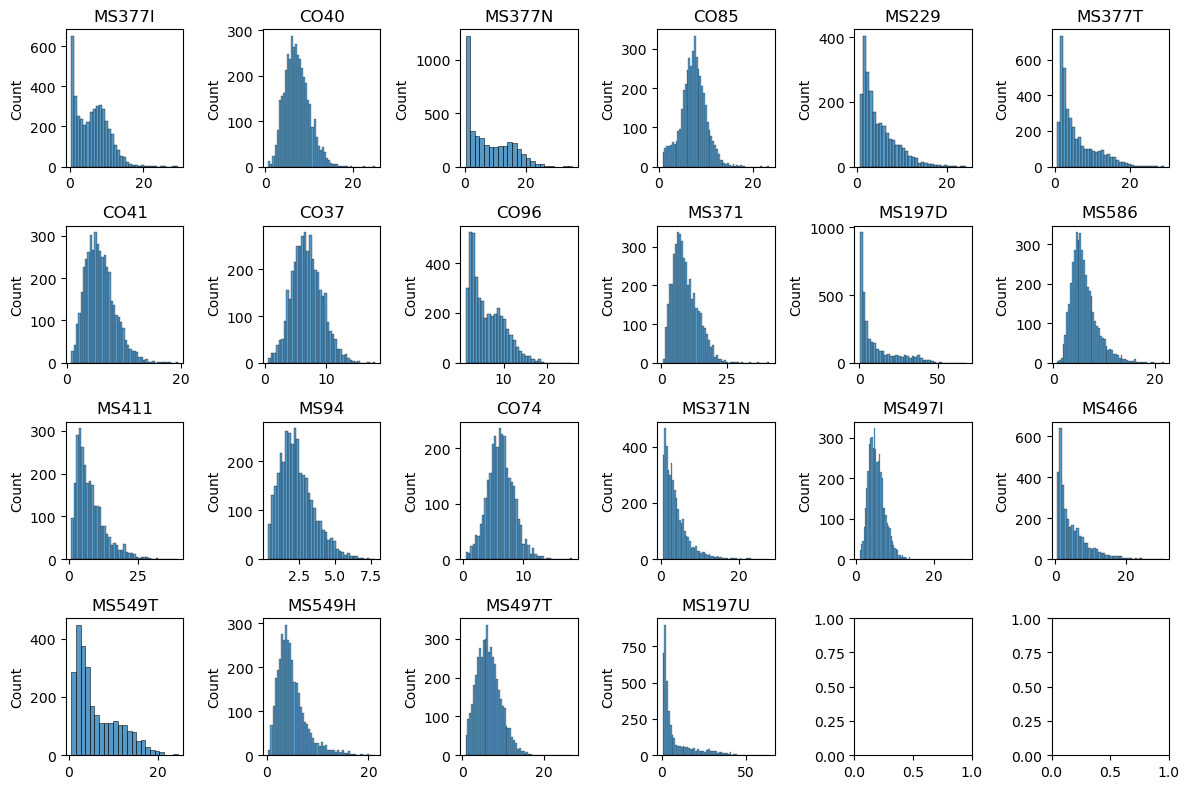

In [22]:
fig, axs = plt.subplots(4, 6, figsize=(12, 8))
axs = axs.flatten()
for i, s in enumerate(visium_samples):
    sns.histplot(vis_dict[s].obsm["abunds_all"].sum(axis=1), ax=axs[i])
    axs[i].set_title(s)
plt.tight_layout()
plt.show()

In [23]:
msigdb = dc.get_resource('MSigDB')

In [24]:
# get hallmark db
hallmark = msigdb[msigdb['collection']=='hallmark'] # filter by hallmark
hallmark = hallmark[~hallmark.duplicated(['geneset', 'genesymbol'])] # remove duplicates
hallmark.loc[:, 'geneset'] = [name.split('HALLMARK_')[1] for name in hallmark['geneset']] # rename for consistency
hallmark = hallmark.loc[:, ['geneset', 'genesymbol']] # reorder columns
hallmark

,geneset,genesymbol
233,IL2_STAT5_SIGNALING,MAFF
250,COAGULATION,MAFF
270,HYPOXIA,MAFF
373,TNFA_SIGNALING_VIA_NFKB,MAFF
377,COMPLEMENT,MAFF
...,...,...
1449668,PANCREAS_BETA_CELLS,STXBP1
1450315,PANCREAS_BETA_CELLS,ELP4
1450526,PANCREAS_BETA_CELLS,GCG
1450731,PANCREAS_BETA_CELLS,PCSK2


In [25]:
# get progeny db
progeny = dc.get_progeny(top=300)
progeny = progeny.rename(columns={'source': 'geneset', 'target': 'genesymbol'})
progeny = progeny.loc[:, ['geneset', 'genesymbol', 'weight']] # reorder columns
progeny

,geneset,genesymbol,weight
0,Androgen,TMPRSS2,11.490631
1,Androgen,NKX3-1,10.622551
2,Androgen,MBOAT2,10.472733
3,Androgen,KLK2,10.176186
4,Androgen,SARG,11.386852
...,...,...,...
4195,p53,MKI67,-5.680340
4196,p53,THOC2,-2.108178
4197,p53,POLA1,-4.943873
4198,p53,TMEM52,2.596648


In [26]:
# get reactome db
reactome = msigdb[msigdb['collection'] == 'reactome_pathways']
reactome = reactome.loc[:, ['geneset', 'genesymbol']] # reorder columns
reactome = reactome[~reactome.duplicated(['geneset', 'genesymbol'])]
reactome

,geneset,genesymbol
200,REACTOME_HEMOSTASIS,MAFF
342,REACTOME_FACTORS_INVOLVED_IN_MEGAKARYOCYTE_DEV...,MAFF
718,REACTOME_INTRACELLULAR_SIGNALING_BY_SECOND_MES...,IER3
859,REACTOME_NEGATIVE_REGULATION_OF_THE_PI3K_AKT_N...,IER3
1104,REACTOME_MITOTIC_G2_G2_M_PHASES,PHLDA1
...,...,...
3838483,REACTOME_DAP12_INTERACTIONS,KIR2DS2
3838489,REACTOME_INNATE_IMMUNE_SYSTEM,KIR2DS2
3838499,REACTOME_ADAPTIVE_IMMUNE_SYSTEM,KIR2DS2
3838530,REACTOME_DAP12_INTERACTIONS,KIR3DS1


In [27]:
len(reactome.geneset.unique())

1654

In [28]:
# checked weighted mean
adata = vis_dict["MS549H"]
pkn = hallmark
pkn_name = "hallmark"
dc.run_wmean(
    mat=adata,
    net=pkn,
    source="geneset",
    target="genesymbol",
    weight="weight" if pkn_name in ["progeny"] else None,
    verbose=True,
    use_raw=True)

Running wmean on mat with 3598 samples and 20205 targets for 50 sources.
Infering activities on 1 batches.


100%|██████████| 1/1 [02:29<00:00, 149.20s/it]


In [29]:
adata.obsm.keys()
wmean_estimate, wmean_norm, wmean_corr, wmean_pvals

KeysView(AxisArrays with keys: spatial, abunds_all, props_all, props_all_ilr, abunds_condition, props_condition, props_condition_ilr, abunds_lesion_type, props_lesion_type, props_lesion_type_ilr, summary, histogram, texture, wmean_estimate, wmean_norm, wmean_corr, wmean_pvals)

In [ ]:
# check ulk
adata = vis_dict["MS549H"]
pkn = hallmark
pkn_name = "hallmark"
dc.run_ulm(
    mat=adata,
    net=pkn,
    source="geneset",
    target="genesymbol",
    weight="weight" if pkn_name in ["progeny"] else None,
    verbose=True,
    use_raw=True)

In [ ]:
adata.obsm.keys()

In [ ]:
for key, adata in vis_dict.items():
    print(key)
    for pkn, pkn_name in zip([hallmark, progeny, reactome], ["hallmark", "progeny", "reactome"]):
        print(pkn_name)
        # run ulm
        dc.run_ulm(
            mat=adata,
            net=pkn,
            source="geneset",
            target="genesymbol",
            weight="weight" if pkn_name in ["progeny"] else None,
            verbose=True,
            use_raw=True)
        adata.obsm[f"{pkn_name}_ulm_estimates"] = adata.obsm["ulm_estimate"]
        adata.obsm[f"{pkn_name}_ulm_pvals"] = adata.obsm["ulm_pvals"]
        del adata.obsm["ulm_estimate"], adata.obsm["ulm_pvals"]
        
        # run wmean
        dc.run_wmean(
            mat=adata,
            net=pkn,
            source="geneset",
            target="genesymbol",
            weight="weight" if pkn_name in ["progeny"] else None,
            verbose=True,
            use_raw=True)
        adata.obsm[f"{pkn_name}_wmean_estimate"] = adata.obsm["wmean_estimate"]
        adata.obsm[f"{pkn_name}_wmean_norm"] = adata.obsm["wmean_norm"]
        adata.obsm[f"{pkn_name}_wmean_corr"] = adata.obsm["wmean_corr"]
        adata.obsm[f"{pkn_name}_wmean_pvals"] = adata.obsm["wmean_pvals"]
        del adata.obsm["wmean_estimate"], adata.obsm["wmean_norm"], adata.obsm["wmean_corr"], adata.obsm["wmean_pvals"]


In [ ]:
vis_dict["CO37"].obsm_keys()

In [ ]:

reactome = msigdb[msigdb['collection'] == 'reactome_pathways']

In [ ]:
reactome = msigdb[msigdb['collection'] == 'reactome_pathways']
reactome